Проводим анализ для компании, которая разрабатывает мобильные игры. Менеджер обозначил задачи по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Нужно написать функцию для его подсчета за нужный период.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных нужно определить, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложить метрики для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import requests
import pingouin as pg
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest

# 1. Смотрим на retention и реализовываем функцию для его подсчета

In [2]:
#Выделяем отдельно путь, где расположены данные  
path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-nikita-smirnov-rrh-5e427/shared/'

In [3]:
#Загружаем данные 
reg_data = pd.read_csv(path + 'problem1-reg_data.csv', sep = ';')
auth_data = pd.read_csv(path + 'problem1-auth_data.csv', sep = ';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


**reg_data** - данные о времени регистрации пользователей\
**auth_data** - данные о времени захода пользователей в игру

# Проводим EDA - предварительный анализ данных

In [4]:
#Проверяем отображение данных
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
#Проверяем размер таблицы (кол-во строк и столбцов)
reg_data.shape

(1000000, 2)

In [6]:
#Проверяем типы данных в столбцах
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [7]:
#Проверяем наличие пропущенных значений
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [8]:
#Проверяем наличие дубликатов по строкам
reg_data.duplicated().sum()

0

In [9]:
#Проверяем отображение данных
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [10]:
#Проверяем размер таблицы (кол-во строк и столбцов)
auth_data.shape

(9601013, 2)

In [11]:
#Проверяем наличие пропущенных значений
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [12]:
#Проверяем наличие дубликатов по строкам
auth_data.duplicated().sum()

0

In [13]:
#Проверяем типы данных в столбцах
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [14]:
#Проверяем, что uid пользователей в двух таблицах одинаковое 
set(reg_data.uid)==set(auth_data.uid)

True

## Выводы:
- Данные **не содержат** дубликатов и пропущенных значений.
- Уникальные пользователи (**uid**) в обоих датафреймах одинаковые.
- **auth_ts** и **reg_ts** представлены как **Unix timestamp  в формате int**.

In [15]:
#Преобразуем auth_ts и reg_ts в формат datetime64
reg_data['reg_ts'] = pd.to_datetime(reg_data.reg_ts, unit = 's')
auth_data['auth_ts'] = pd.to_datetime(auth_data.auth_ts, unit = 's')

In [88]:
#Проверяем изменения типа данных
print(reg_data.dtypes)
print(auth_data.dtypes)

reg_ts    datetime64[ns]
uid                int64
dtype: object
auth_ts    datetime64[ns]
uid                 int64
dtype: object


In [17]:
#Проверям вывод данных
print(reg_data.head(1))
print(auth_data.head(1))

               reg_ts  uid
0 1998-11-18 09:43:43    1
              auth_ts  uid
0 1998-11-18 09:43:43    1


# Объединяем данные

In [18]:
#Обогащаем данные авторизации, путем объединения с данными регистрации
df = auth_data.merge(reg_data, on = 'uid', how ='left')

In [19]:
df.head()

,auth_ts,uid,reg_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-25 16:46:46,2,1999-07-22 22:38:09
3,1999-07-31 03:50:15,2,1999-07-22 22:38:09
4,1999-08-05 17:49:39,2,1999-07-22 22:38:09


Повторно проверяем, что объединение прошло корректно:

In [20]:
#Проверяем наличие пропущенных значений
df.isna().sum()

auth_ts    0
uid        0
reg_ts     0
dtype: int64

In [21]:
#Проверка на наличие дубликатов
df.duplicated().sum()

0

In [22]:
#Проверка сохранности числа строк после объединения
df.shape[0] == auth_data.shape[0]

True

# Анализ данных о времени

In [23]:
#Первая дата регистрации
df.reg_ts.min()

Timestamp('1998-11-18 09:43:43')

In [24]:
#Последняя дата регистрации
df.reg_ts.max()

Timestamp('2020-09-23 15:17:24')

In [25]:
#Первая дата авторизация
df.auth_ts.min()

Timestamp('1998-11-18 09:43:43')

In [26]:
#Последняя авторизация
df.auth_ts.max()

Timestamp('2020-09-23 15:17:24')

In [27]:
#Проверяем, что авторизация не происходила раньше регистрации (построчно)
(df.auth_ts >= df.reg_ts).all()

True

Видим,что разброс данных во времени составляет - **22 года**;\
А также, что характер данных не содержит таких аномалий, как более раняя авторизация относительно регистрации.

# Расчет retention на отрезке данных
Для расчёта дневного retention обычно используются интервалы до 30 дней, т.к. анализ более длинных периодов может терять детализацию и становится менее наглядным. Поэтому для предварительного анализа и тестирования расчётов выбрал выборку за последний полный месяц (август 2020), чтобы:

- иметь достаточный объём данных;

- получить завершённые когорты (где возможен полный цикл анализа на протяжении 30 дней);

- использовать удобный и логичный отрезок для дальнейшего сравнения и проверки функции.

In [28]:
#Задаем нужный диапазон
start = pd.to_datetime('2020-08-01').date()
end =  pd.to_datetime('2020-08-31').date()


In [29]:
# Извлекаем день регистрации
df['cohort_day'] = df['reg_ts'].dt.date

In [30]:
#Извлекаем день авторизации
df['auth_day'] = df['auth_ts'].dt.date

In [31]:
#Создаем копию для защиты от SettingWithCopyWarning
df_2020_08 = df.copy()

In [32]:
#Проверяем данные
df_2020_08

,auth_ts,uid,reg_ts,cohort_day,auth_day
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43,1998-11-18,1998-11-18
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09,1999-07-22,1999-07-22
2,1999-07-25 16:46:46,2,1999-07-22 22:38:09,1999-07-22,1999-07-25
3,1999-07-31 03:50:15,2,1999-07-22 22:38:09,1999-07-22,1999-07-31
4,1999-08-05 17:49:39,2,1999-07-22 22:38:09,1999-07-22,1999-08-05
...,...,...,...,...,...
9601008,2020-09-23 15:13:54,1110618,2020-09-23 15:13:54,2020-09-23,2020-09-23
9601009,2020-09-23 15:14:46,1110619,2020-09-23 15:14:46,2020-09-23,2020-09-23
9601010,2020-09-23 15:15:39,1110620,2020-09-23 15:15:39,2020-09-23,2020-09-23
9601011,2020-09-23 15:16:31,1110621,2020-09-23 15:16:31,2020-09-23,2020-09-23


In [33]:
#Для тестирования, формируем датафрейм по выбранному интервалу времени
df_2020_08 = df_2020_08[
                (df_2020_08['cohort_day'] >= start) & (df_2020_08['cohort_day'] <= end) &
                (df_2020_08['auth_day'] >= start) & (df_2020_08['auth_day'] <= end)
               ].copy() 

In [34]:
#Проверяем вывод после фильтрации
df_2020_08

,auth_ts,uid,reg_ts,cohort_day,auth_day
8787496,2020-08-01 00:00:04,1016863,2020-08-01 00:00:04,2020-08-01,2020-08-01
8787509,2020-08-01 00:01:01,1016864,2020-08-01 00:01:01,2020-08-01,2020-08-01
8787521,2020-08-01 00:01:59,1016865,2020-08-01 00:01:59,2020-08-01,2020-08-01
8787529,2020-08-01 00:02:56,1016866,2020-08-01 00:02:56,2020-08-01,2020-08-01
8787535,2020-08-01 00:03:53,1016867,2020-08-01 00:03:53,2020-08-01,2020-08-01
...,...,...,...,...,...
9249149,2020-08-31 23:57:38,1039143,2020-08-14 04:01:50,2020-08-14,2020-08-31
9249153,2020-08-31 23:58:24,1070032,2020-08-31 23:58:24,2020-08-31,2020-08-31
9249155,2020-08-31 23:58:34,1026806,2020-08-06 21:58:52,2020-08-06,2020-08-31
9249158,2020-08-31 23:58:59,1056981,2020-08-24 12:09:32,2020-08-24,2020-08-31


In [35]:
df_2020_08.shape

(81188, 5)

In [36]:
#Рассчитыаем период с момента регистрации до авторизации
df_2020_08['period'] = (df_2020_08['auth_day'] - df_2020_08['cohort_day']).dt.days

In [37]:
df_2020_08

,auth_ts,uid,reg_ts,cohort_day,auth_day,period
8787496,2020-08-01 00:00:04,1016863,2020-08-01 00:00:04,2020-08-01,2020-08-01,0
8787509,2020-08-01 00:01:01,1016864,2020-08-01 00:01:01,2020-08-01,2020-08-01,0
8787521,2020-08-01 00:01:59,1016865,2020-08-01 00:01:59,2020-08-01,2020-08-01,0
8787529,2020-08-01 00:02:56,1016866,2020-08-01 00:02:56,2020-08-01,2020-08-01,0
8787535,2020-08-01 00:03:53,1016867,2020-08-01 00:03:53,2020-08-01,2020-08-01,0
...,...,...,...,...,...,...
9249149,2020-08-31 23:57:38,1039143,2020-08-14 04:01:50,2020-08-14,2020-08-31,17
9249153,2020-08-31 23:58:24,1070032,2020-08-31 23:58:24,2020-08-31,2020-08-31,0
9249155,2020-08-31 23:58:34,1026806,2020-08-06 21:58:52,2020-08-06,2020-08-31,25
9249158,2020-08-31 23:58:59,1056981,2020-08-24 12:09:32,2020-08-24,2020-08-31,7


In [38]:
# Агрегируем данные по когортам и рассчитанному номеру периода (в днях)
df_cohort = df_2020_08.groupby(['cohort_day', 'period']).agg(uid=('uid', 'nunique')).reset_index()

In [39]:
df_cohort

,cohort_day,period,uid
0,2020-08-01,0,1507
1,2020-08-01,1,29
2,2020-08-01,2,67
3,2020-08-01,3,65
4,2020-08-01,4,84
...,...,...,...
491,2020-08-29,1,40
492,2020-08-29,2,59
493,2020-08-30,0,1580
494,2020-08-30,1,29


In [40]:
#Создаем сводную таблицу для когортного анализа
cohort_pivot = df_cohort.pivot_table(index='cohort_day', columns='period', values='uid')

In [41]:
cohort_pivot

period,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
cohort_day,,,,,,,,,,,,,,,,,,,,,
2020-08-01,1507.0,29.0,67.0,65.0,84.0,89.0,115.0,96.0,68.0,96.0,...,51.0,61.0,57.0,63.0,62.0,38.0,47.0,48.0,46.0,41.0
2020-08-02,1509.0,39.0,61.0,66.0,78.0,98.0,100.0,91.0,68.0,80.0,...,69.0,58.0,59.0,60.0,49.0,51.0,45.0,51.0,50.0,NaN
2020-08-03,1512.0,26.0,65.0,61.0,84.0,93.0,114.0,80.0,75.0,74.0,...,62.0,66.0,45.0,59.0,48.0,66.0,51.0,49.0,NaN,NaN
2020-08-04,1514.0,31.0,54.0,71.0,79.0,80.0,98.0,78.0,67.0,71.0,...,60.0,46.0,67.0,44.0,48.0,45.0,48.0,NaN,NaN,NaN
2020-08-05,1517.0,39.0,53.0,61.0,87.0,77.0,118.0,93.0,64.0,72.0,...,51.0,50.0,50.0,57.0,45.0,54.0,NaN,NaN,NaN,NaN
2020-08-06,1519.0,26.0,77.0,87.0,85.0,87.0,114.0,92.0,76.0,88.0,...,58.0,59.0,51.0,58.0,47.0,NaN,NaN,NaN,NaN,NaN
2020-08-07,1522.0,33.0,47.0,80.0,81.0,91.0,109.0,94.0,78.0,76.0,...,72.0,47.0,58.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-08,1524.0,37.0,73.0,64.0,83.0,83.0,110.0,96.0,60.0,73.0,...,54.0,66.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-09,1527.0,32.0,60.0,71.0,82.0,108.0,96.0,101.0,68.0,75.0,...,60.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# Рассчитываем размеры когорт (первый столбец сводной таблицы)
cohort_size = cohort_pivot.iloc[:, 0]

In [43]:
# Вычисляем коэффициенты удержания, деля на размер когорты
retention_matrix = round(cohort_pivot.divide(cohort_size, axis=0),4)

In [44]:
#Проверяем матрцу retention
retention_matrix

period,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
cohort_day,,,,,,,,,,,,,,,,,,,,,
2020-08-01,1.0,0.0192,0.0445,0.0431,0.0557,0.0591,0.0763,0.0637,0.0451,0.0637,...,0.0338,0.0405,0.0378,0.0418,0.0411,0.0252,0.0312,0.0319,0.0305,0.0272
2020-08-02,1.0,0.0258,0.0404,0.0437,0.0517,0.0649,0.0663,0.0603,0.0451,0.0530,...,0.0457,0.0384,0.0391,0.0398,0.0325,0.0338,0.0298,0.0338,0.0331,NaN
2020-08-03,1.0,0.0172,0.0430,0.0403,0.0556,0.0615,0.0754,0.0529,0.0496,0.0489,...,0.0410,0.0437,0.0298,0.0390,0.0317,0.0437,0.0337,0.0324,NaN,NaN
2020-08-04,1.0,0.0205,0.0357,0.0469,0.0522,0.0528,0.0647,0.0515,0.0443,0.0469,...,0.0396,0.0304,0.0443,0.0291,0.0317,0.0297,0.0317,NaN,NaN,NaN
2020-08-05,1.0,0.0257,0.0349,0.0402,0.0574,0.0508,0.0778,0.0613,0.0422,0.0475,...,0.0336,0.0330,0.0330,0.0376,0.0297,0.0356,NaN,NaN,NaN,NaN
2020-08-06,1.0,0.0171,0.0507,0.0573,0.0560,0.0573,0.0750,0.0606,0.0500,0.0579,...,0.0382,0.0388,0.0336,0.0382,0.0309,NaN,NaN,NaN,NaN,NaN
2020-08-07,1.0,0.0217,0.0309,0.0526,0.0532,0.0598,0.0716,0.0618,0.0512,0.0499,...,0.0473,0.0309,0.0381,0.0388,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-08,1.0,0.0243,0.0479,0.0420,0.0545,0.0545,0.0722,0.0630,0.0394,0.0479,...,0.0354,0.0433,0.0335,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-09,1.0,0.0210,0.0393,0.0465,0.0537,0.0707,0.0629,0.0661,0.0445,0.0491,...,0.0393,0.0413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
#Убираем нулевую колонку, чтобы визуализация retention была более показательной
retention_matrix = retention_matrix.drop(columns=0, errors='ignore')

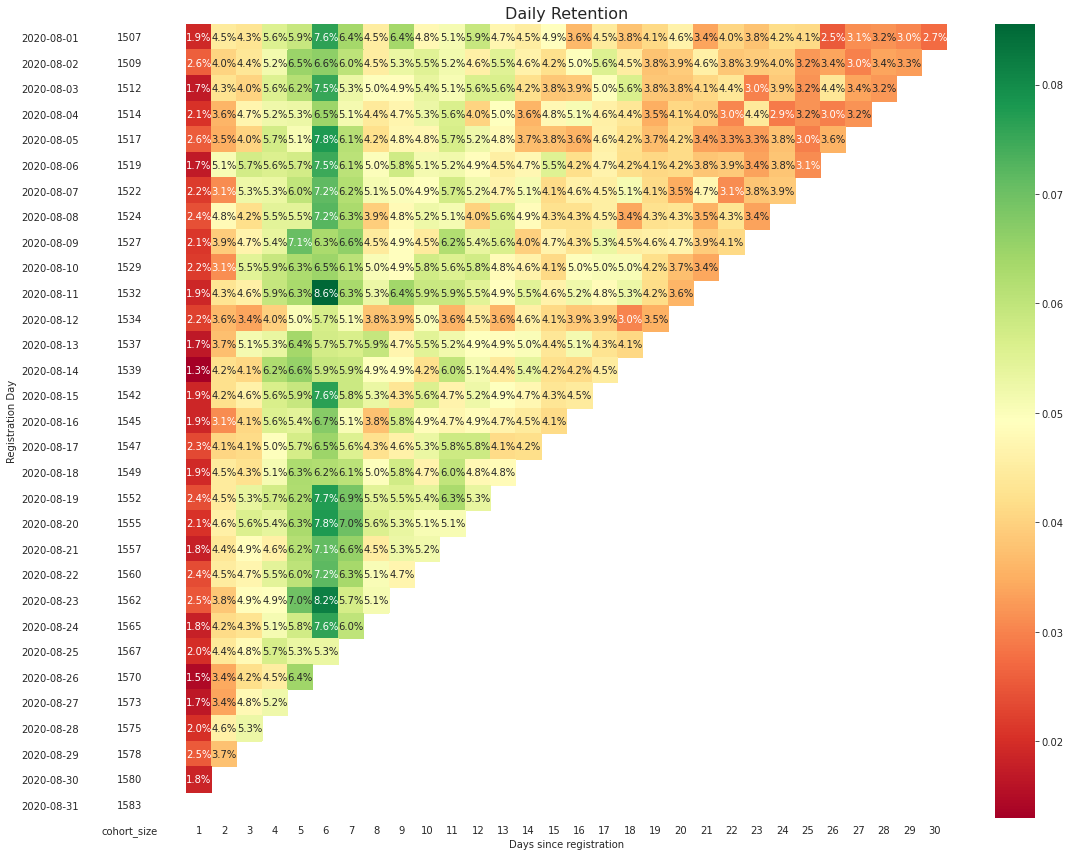

In [46]:
# Строим тепловую карту когортного анализа
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
 
    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.1%', 
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Daily Retention', fontsize=16)
    ax[1].set(xlabel='Days since registration',  ylabel='')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])
    ax[0].set_ylabel('Registration Day')
    fig.tight_layout()
    plt.show()

# Упаковываем в функцию

В функцию не включено считывание файлов, чтобы сохранить гибкость и возможность использовать разные источники, формат данных.
В рамках поставленной задачи предполагается наличие полного датасета с необходимыми данными, и ранее был проведён EDA именно на этом наборе. Поэтому функция опирается на структуру и особенности конкретно этого датасета, и не включает в себя обработку потенциальных аномалий или адаптацию под другие данные.

## Ответ:

In [47]:
def f_retention(reg_data, auth_data, start=None, end=None, show_heatmap=True):
    
    """
    Рассчитывает дневной retention (удержание) пользователей по когортам.
    Аргументы, которые подаются на вход:
            reg_data: датафрейм с данными о регистрации. 
            Содержит колонки:
                - 'uid' (уникальный идентификатор пользователя)
                - 'reg_ts' (дата и время регистрации) Unix timestamp в формате int.
            auth_data: Датафрейм с данными об авторизациях. 
            Содержит колонки:
                - 'uid' (уникальный идентификатор пользователя)
                - 'auth_ts' (дата и время авторизации) Unix timestamp в формате int.
            start (str): Дата начала анализа в формате 'YYYY-MM-DD'.
            end (str): Дата окончания анализа в формате 'YYYY-MM-DD'. 
            show_heatmap (bool): Отображать ли heatmap с retention (по умолчанию True).

        Возвращает:
            retention_matrix: Матрица удержания (retention) по когортам.
            
        Дополнительно: 
            Визуализирует тепловую карту retention.
    """
    #Преобразуем auth_ts и reg_ts в нужный формат
    reg_data['reg_ts'] = pd.to_datetime(reg_data.reg_ts, unit = 's')
    auth_data['auth_ts'] = pd.to_datetime(auth_data.auth_ts, unit = 's')
    
    #Объединяем данные авторизации с данными регистрации
    df = auth_data.merge(reg_data, on = 'uid', how ='left')
    
    #Преобразуем, запрашиваемый диапазон в нужный формат
    start_date = pd.to_datetime(start).date()
    end_date =  pd.to_datetime(end).date()
        
    #Извлекаем день регистрации и авторизации
    df['cohort_day'] = df['reg_ts'].dt.date
    df['auth_day'] = df['auth_ts'].dt.date
        
    #Фильтруем по нужной дате
    df_2 = df[
           (df['cohort_day'] >= start_date) & (df['cohort_day'] <= end_date) &
           (df['auth_day'] >= start_date) & (df['auth_day'] <= end_date)
               ].copy() 
    #Рассчитыаем период с момента регистрации до авторизации
    df_2['period'] = (df_2['auth_day'] - df_2['cohort_day']).dt.days
    
    # Агрегируем данные по когортам и рассчитанному номеру периода (в днях)
    df_cohort = df_2.groupby(['cohort_day', 'period']).agg(uid=('uid', 'nunique')).reset_index()
    
    # Создаем сводную таблицу для когортного анализа
    cohort_pivot = df_cohort.pivot_table(index='cohort_day', columns='period', values='uid')
    
    # Рассчитываем размеры когорт (первый столбец сводной таблицы)
    cohort_size = cohort_pivot.iloc[:, 0]
    
    # Вычисляем коэффициенты удержания, деля на размер когорты
    retention_matrix = round(cohort_pivot.divide(cohort_size, axis=0),4)
    
    #Убираем нулевую колонку, чтобы визуализация retention была более показательной
    retention_matrix = retention_matrix.drop(columns=0, errors='ignore')
    
    #Задаем условие для отображения карты
    if show_heatmap:
        with sns.axes_style("white"):
            fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
 
            # Тепловая карта для коэффициентов удержания
            sns.heatmap(retention_matrix,
                        mask=retention_matrix.isnull(),
                        annot=True,
                        fmt='.1%', 
                        cmap='RdYlGn',
                        ax=ax[1])
            ax[1].set_title('Daily Retention', fontsize=16)
            ax[1].set(xlabel='Days since registration', ylabel='')

            # Тепловая карта для размеров когорт
            cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
            white_cmap = mcolors.ListedColormap(['white'])
            sns.heatmap(cohort_size_df,
                        annot=True,
                        cbar=False,
                        fmt='g',
                        cmap=white_cmap,
                        ax=ax[0])
            ax[0].set_ylabel('Registration Day')
            fig.tight_layout()
            plt.show()
    return retention_matrix

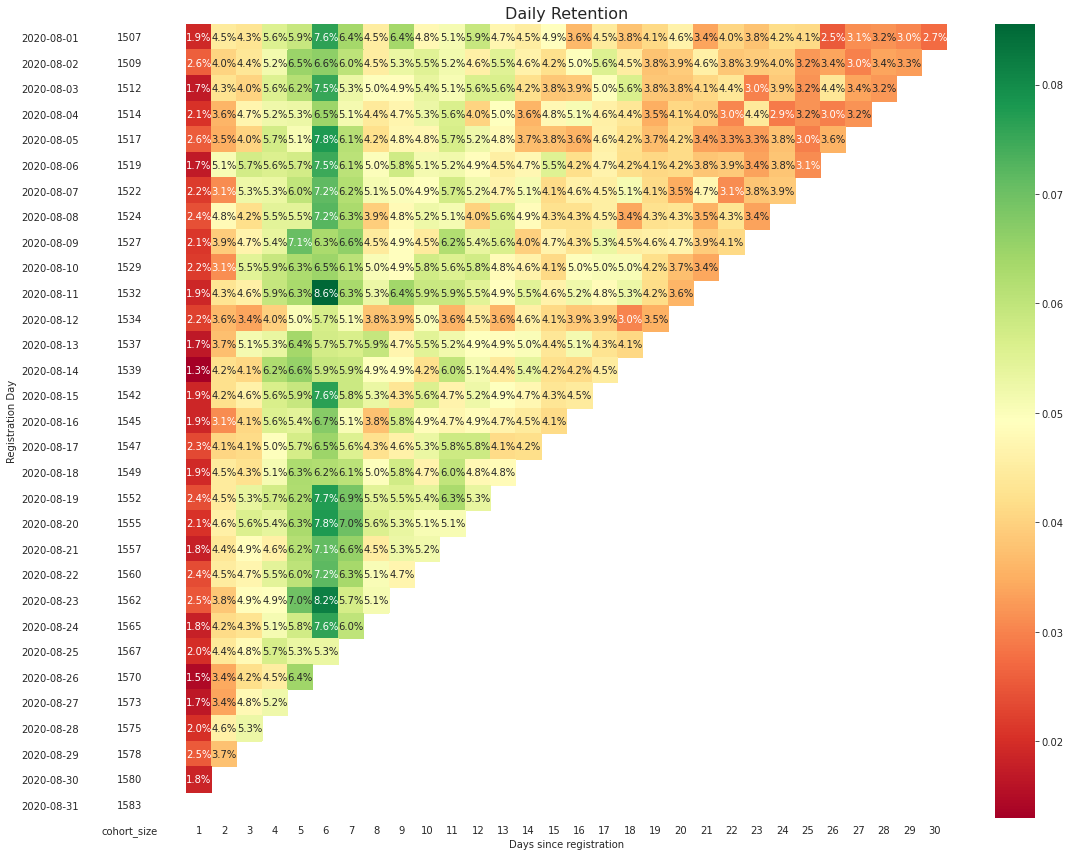

period,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
cohort_day,,,,,,,,,,,,,,,,,,,,,
2020-08-01,0.0192,0.0445,0.0431,0.0557,0.0591,0.0763,0.0637,0.0451,0.0637,0.0478,...,0.0338,0.0405,0.0378,0.0418,0.0411,0.0252,0.0312,0.0319,0.0305,0.0272
2020-08-02,0.0258,0.0404,0.0437,0.0517,0.0649,0.0663,0.0603,0.0451,0.0530,0.0550,...,0.0457,0.0384,0.0391,0.0398,0.0325,0.0338,0.0298,0.0338,0.0331,NaN
2020-08-03,0.0172,0.0430,0.0403,0.0556,0.0615,0.0754,0.0529,0.0496,0.0489,0.0536,...,0.0410,0.0437,0.0298,0.0390,0.0317,0.0437,0.0337,0.0324,NaN,NaN
2020-08-04,0.0205,0.0357,0.0469,0.0522,0.0528,0.0647,0.0515,0.0443,0.0469,0.0528,...,0.0396,0.0304,0.0443,0.0291,0.0317,0.0297,0.0317,NaN,NaN,NaN
2020-08-05,0.0257,0.0349,0.0402,0.0574,0.0508,0.0778,0.0613,0.0422,0.0475,0.0475,...,0.0336,0.0330,0.0330,0.0376,0.0297,0.0356,NaN,NaN,NaN,NaN
2020-08-06,0.0171,0.0507,0.0573,0.0560,0.0573,0.0750,0.0606,0.0500,0.0579,0.0513,...,0.0382,0.0388,0.0336,0.0382,0.0309,NaN,NaN,NaN,NaN,NaN
2020-08-07,0.0217,0.0309,0.0526,0.0532,0.0598,0.0716,0.0618,0.0512,0.0499,0.0493,...,0.0473,0.0309,0.0381,0.0388,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-08,0.0243,0.0479,0.0420,0.0545,0.0545,0.0722,0.0630,0.0394,0.0479,0.0525,...,0.0354,0.0433,0.0335,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-09,0.0210,0.0393,0.0465,0.0537,0.0707,0.0629,0.0661,0.0445,0.0491,0.0445,...,0.0393,0.0413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
#Вызываем функцию и подаём на вход те же данные и диапазон, по которым ранее делали ручной расчёт, для проверки корректности
f_retention(reg_data, auth_data, start='2020-08-01', end='2020-08-31', show_heatmap=True)

Видим, что функция работает корректно (результат совпадает с проведенным ранее ручным расчетом)

In [49]:
#Проверяем описание функции
help(f_retention)

Help on function f_retention in module __main__:

f_retention(reg_data, auth_data, start=None, end=None, show_heatmap=True)
    Рассчитывает дневной retention (удержание) пользователей по когортам.
    Аргументы, которые подаются на вход:
            reg_data: датафрейм с данными о регистрации. 
            Содержит колонки:
                - 'uid' (уникальный идентификатор пользователя)
                - 'reg_ts' (дата и время регистрации) Unix timestamp в формате int.
            auth_data: Датафрейм с данными об авторизациях. 
            Содержит колонки:
                - 'uid' (уникальный идентификатор пользователя)
                - 'auth_ts' (дата и время авторизации) Unix timestamp в формате int.
            start (str): Дата начала анализа в формате 'YYYY-MM-DD'.
            end (str): Дата окончания анализа в формате 'YYYY-MM-DD'. 
            show_heatmap (bool): Отображать ли heatmap с retention (по умолчанию True).
    
        Возвращает:
            retention_matrix: Ма

# 2. Определяем лучший набор метрик на основании А/В теста
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

# Анализ условий A/B теста

Чтобы корректно оценить результаты тестирования, в первую очередь необходимо определить гипотезу и метрики, которые будут удовлетворять требованиям анализа.

Гипотеза: **"Изменение набора акционных предложений в тестовой группе увеличит покупательскую способность пользователей"** 

По полученной информации мы видим, что рассчитана метрика **ARPU** - средний доход на пользователя. Также количество платящих пользователей относительно общего числа - достаточно низкое. При низкой доле платящих пользователей **ARPU** может искажать реальную картину: метрика усредняется нулевыми значениями и не отражает поведение платящих пользователей.

Стоит обратить внимание на следующие метрики: 
- **ARPPU** - средний доход на платещего пользователя
- **CR** -  конверсия в платящего пользователя.

# Подключение к файлам из яндекс диска с помощью API

In [50]:
#Формируем ссылку на нужный файл в яндекс диске
data_link = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

In [51]:
 def get_file_content(public_link):
    """
        Возвращает датафрейм полученный по ссылке с Яндекс диска. 
        На вход принимает публичную ссылку. 
    """
    api_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download"
    params = {"public_key": public_link}

    response = requests.get(api_url, params=params)
    if response.status_code == 200:
        download_url = response.json()["href"]

        df = pd.read_csv(download_url, sep =';')
        return df
    else:
        print("Ошибка при получении ссылки:", response.json())

In [52]:
#Загружаем таблицу с данными A/B теста
df_ab = get_file_content(data_link)

# Проводим EDA - предварительный анализ данных

In [53]:
#Проверяем отображение данных
df_ab.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [54]:
#Проверяем размер таблицы (кол-во строк и столбцов)
df_ab.shape

(404770, 3)

In [55]:
#Проверяем тип данных в столбцах
df_ab.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [56]:
#Проверяем наличие пропущенных значений
df_ab.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [57]:
#Проверяем наличие дубликатов по строкам
df_ab.duplicated().sum()

0

In [58]:
#Проверим кол-во уникальных user_id
df_ab.user_id.nunique()

404770

Приходим к выводу, что все пользователи, представленные в таблице - уникальные. Значит данные находятся на уровне пользователя и дополнительная группировка по user_id в дальнейшем не понадобится.

In [59]:
#Посмотрим на описательную статистику revenue
df_ab.revenue.describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

**Выводы:**
- revenue лежит в диапазоне от 0 до 37433 ;
- Среднее значение ~ 26, но при этом медиана (50%) = 0, что указывает на сильную асимметрию распределения;
- 75% пользователей имеют revenue = 0, то есть основная масса не приносит выручки;
- Распределение данных имеет сильные выбросы, что влияет на среднее значение;
- Отсутствую пропущенные значения и дубликаты;
- Все пользователи, представленные в данных - уникальные.

# Проверим данные на соответствие полученной информации

In [60]:
#Проверям общее количество пользователей в каждой группе
df_ab.testgroup.value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

Мы видим,что к контрольной группе относятся 202103 пользователя, из чего делаем вывод, что группа **a - контрольная**, группа **b - тестовая.** 

In [61]:
print(f"Общее количество пользователей в контрольной группе составляет -  {df_ab.testgroup.value_counts()['a']}")
print(f"Общее количество пользователей в тестовой группе составляет -  {df_ab.testgroup.value_counts()['b']}")

Общее количество пользователей в контрольной группе составляет -  202103
Общее количество пользователей в тестовой группе составляет -  202667


In [62]:
#Отфильтруем данные по платящим пользователям
df_paying = df_ab[df_ab['revenue']>0]

In [63]:
#Проверим количество платящих пользователей в каждой группе
df_paying.testgroup.value_counts()

a    1928
b    1805
Name: testgroup, dtype: int64

In [64]:
print(f"Количество платящих пользователей в контрольной группе составляет -  {df_paying.testgroup.value_counts()['a']}")
print(f"Количество платящих пользователей в тестовой группе составляет -  {df_paying.testgroup.value_counts()['b']}")

Количество платящих пользователей в контрольной группе составляет -  1928
Количество платящих пользователей в тестовой группе составляет -  1805


In [65]:
#Формируем данные по группам для проведения дальнеших расчетов и тестов
сontrol = df_ab[df_ab['testgroup']=='a']
test = df_ab[df_ab['testgroup']=='b']

In [66]:
#Расчитаем ARPU для каждой группы и его разницу между ними
ARPU_a = (сontrol.revenue.sum())/(сontrol.user_id.nunique())
ARPU_b = (test.revenue.sum())/(test.user_id.nunique())
ARPU_dif = (ARPU_b-ARPU_a)/ARPU_a

In [67]:
print(f"ARPU в контрольной группе составляет - {ARPU_a:.2f}")
print(f"ARPU в тестовой группе составляет - {ARPU_b:.2f}")
print(f"ARPU в тестовой группе на {ARPU_dif:.0%} больше, чем в контрольной")

ARPU в контрольной группе составляет - 25.41
ARPU в тестовой группе составляет - 26.75
ARPU в тестовой группе на 5% больше, чем в контрольной


**Выводы**
- Общее кол-во, кол-во платящих пользователей в группах и разница ARPU соответствуют озвученной информации. 
- Численность пользователей в группах примерно одинаковая (в том числе платящих).

# Посмотрим на распределение данных в группах

In [68]:
#Задаем параметры для графиков
sns.set(rc = {'figure.figsize' : (12,8)}, style = "whitegrid")

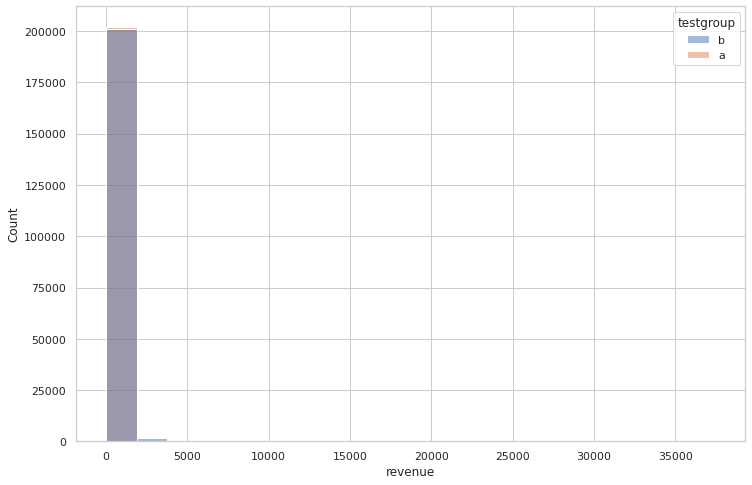

In [69]:
#Смотрим распределение revenue по группам для всех пользователей
sns.histplot(data = df_ab, x = 'revenue', hue = 'testgroup')

Из-за большого количества клиентов, которые не приносят прибыль - график не сильно информативен.

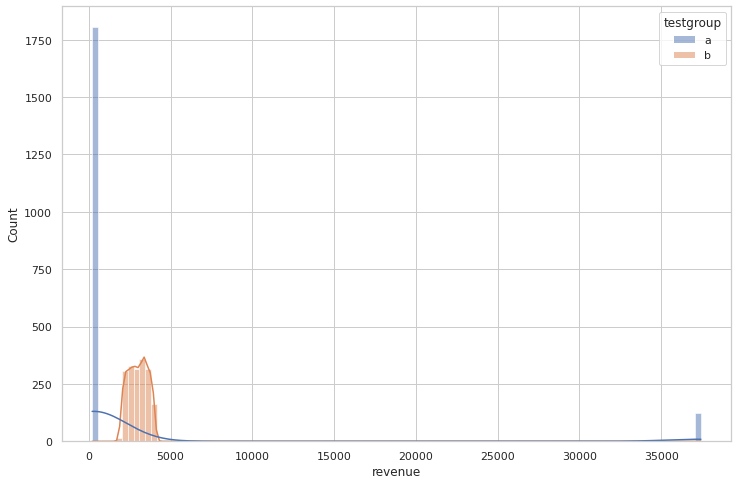

In [70]:
#Распределение revenue по платящим клиентам
sns.histplot(data = df_paying, x = 'revenue', hue = 'testgroup', kde = True)

Мы видим, что распределение в контрольной группе является ненормальным с наличием выбросов, в тестовой группе распределение напоминает нормальное. Изучим их по отдельности.

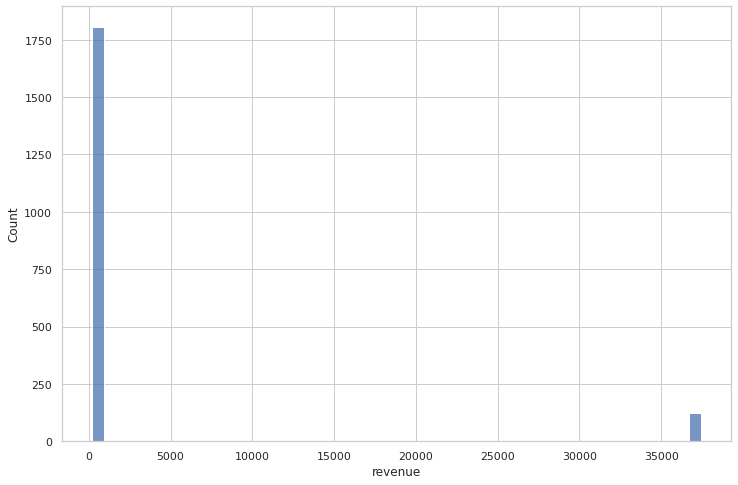

In [71]:
#Распределение revenue по платящим пользователям в контрольной группе
sns.histplot(data = сontrol.query("revenue > 0"), x = 'revenue', bins = 50)

In [72]:
#Изучим описательную статистику revenue у платящих пользователей в контрольной группе
сontrol.query("revenue > 0").revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

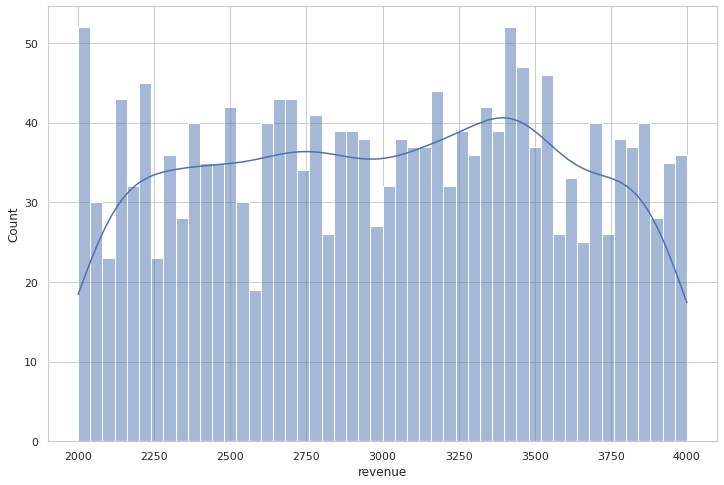

In [73]:
#Распределение revenue по платящим пользователям в тестовой группе
sns.histplot(data = test.query("revenue > 0"), x = 'revenue', bins = 50, kde = True)

In [74]:
#Изучим описательную статистику revenue у платящих клиентов в тестовой группе
test.query("revenue > 0").revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

**Вывод:**

На основе анализа распределения revenue у платящих пользователей можно сделать вывод, что данные в контрольной и тестовой группах имеют различную структуру.

В контрольной группе наблюдаются сильные выбросы — единичные пользователи с очень высоким доходом, что приводит к значительному увеличению стандартного отклонения (std ≈ 9049 против 572 в тестовой). Характер этих выбросов нам не известен и мы не можем их убрать, чтобы упростить анализ - возможно это постоянные клиенты, совершавшие крупные покупки. В то же время в тестовой группе распределение более равномерное, без экстремальных значений.

Такая разница в распределениях и дисперсиях может свидетельствовать о возможных нарушениях в процессе рандомизации или ошибках при сегментации пользователей на группы.

Следовательно, результаты A/B теста могут быть смещены, и полученные статистические различия следует интерпретировать с осторожностью.

# Проведем расчет, выбранных метрик для каждой группы

## ARPPU

In [75]:
ARPPU_a = (сontrol.query('revenue>0').revenue.sum())/(сontrol.query('revenue>0').user_id.nunique())
ARPPU_b = (test.query('revenue>0').revenue.sum())/(test.query('revenue>0').user_id.nunique())
ARPPU_dif = (ARPPU_b-ARPPU_a)/ARPPU_a

In [76]:
print(f"ARPPU в контрольной группе составляет - {ARPPU_a:.2f}")
print(f"ARPPU в тестовой группе составляет - {ARPPU_b:.2f}")
print(f"ARPPU в тестовой группе выше на {ARPPU_dif:.0%}, чем в контрольной")

ARPPU в контрольной группе составляет - 2664.00
ARPPU в тестовой группе составляет - 3003.66
ARPPU в тестовой группе выше на 13%, чем в контрольной


## CR

In [77]:
CR_a = (сontrol.query('revenue>0').user_id.nunique())/(сontrol.user_id.nunique())
CR_b = (test.query('revenue>0').user_id.nunique())/(test.user_id.nunique())
CR_dif = (CR_b-CR_a)/CR_a

In [78]:
print(f"CR в контрольной группе составляет - {CR_a:.2%}")
print(f"CR в тестовой группе составляет - {CR_b:.2%}")
print(f"CR в тестовой группе ниже на {abs(CR_dif):.0%}, чем в контрольной")

CR в контрольной группе составляет - 0.95%
CR в тестовой группе составляет - 0.89%
CR в тестовой группе ниже на 7%, чем в контрольной


**Выводы:**


- ARPU в тестовой группе выше на 5%, чем в контрольной
- ARPPU в тестовой группе выше на 13%, чем в контрольной
- CR в тестовой группе ниже на 7%, чем в контрольной

# Проведение статистических тестов по выбранным метрикам

# ARPU
*Гипотезы:*

- **H0** - ARPU в контрольной и тестовой группе не различаются
- **H1** - ARPU в контрольной и тестовой группе различаются

Для этой метрики мы смотрим на revenue по всем пользователям (df_ab).

In [79]:
#Проверяем распределения на нормальность
pg.normality(data = df_ab, dv = 'revenue', group = 'testgroup', method = 'normaltest')


,W,pval,normal
b,326622.395409,0.0,False
a,585152.731273,0.0,False


Т.к. в каждой группе у нас большая выборка (более 200 000 пользователей), используем тест Д'Агостино-Пирсона (**normaltest**). По результатам теста revenue в обеих группах распределено **ненормально** (p < 0.05)

In [80]:
#Проверяем на гомогенность с помощью теста Левена
pg.homoscedasticity(data=df_ab, dv="revenue", group="testgroup")

,W,pval,equal_var
levene,0.389629,0.532495,True


По результатам теста - **дисперсии равны** (p > 0.05). 

Несмотря на нарушение нормальности, благодаря большому объему выборки, можно опираться на Центральную предельную теорему и использовать параметрический t-тест.Поэтому далее для сравнения ARPU применяем классический t-критерий.

In [81]:
#Проводим t- test
stat, pval = st.ttest_ind(сontrol.revenue, test.revenue, equal_var = True)
if pval < 0.05:
    print(f" p = {pval:.3f} (меньше 0.05). Есть статистически значимые различия. Нулевая гипотеза отклоняется")
else: 
    print(f" p = {pval:.3f} (больше 0.05). Нет статистически значимых различий. Нулевая гипотеза не отклоняется")


 p = 0.532 (больше 0.05). Нет статистически значимых различий. Нулевая гипотеза не отклоняется


**Вывод:** статистически значимых различий по ARPU между контрольной и тестовой группами не выявлено (p > 0.05), следовательно **нет оснований отврегнуть нулевую гипотезу.**

# ARPPU
*Гипотезы:*

- **H0** - ARPPU в контрольной и тестовой группе не различаются
- **H1** - ARPPU в контрольной и тестовой группе различаются

Для этой метрики мы ориентируемся на revenue только по платящим пользователям (df_paying)


In [82]:
#Проверка на нормальность. Так как выборка < 5000, используем тест Шапиро–Уилка
pg.normality(data = df_paying, dv = 'revenue',group = 'testgroup', method = 'shapiro')

,W,pval,normal
a,0.266792,0.000000e+00,False
b,0.958312,2.491346e-22,False


По результатам теста revenue в группах распределено **ненормально**.

In [83]:
#Проверка на гомогенность с помощью теста Левена
pg.homoscedasticity(data=df_paying, dv="revenue", group="testgroup")

,W,pval,equal_var
levene,80.855674,3.779690e-19,False


По результатам теста - **дисперсии разные** (p < 0.05). Поэтому для сравнения ARPPU применяем t-критерий Уэлча. 

In [84]:
#Проводим тест Уэлча и выводим результат
stat, pval = st.ttest_ind(df_paying.query("testgroup=='a'").revenue, df_paying.query("testgroup=='b'").revenue, equal_var = False )

if pval < 0.05:
    print(f" p = {pval:.3f} (меньше 0.05). Есть статистически значимые различия. Нулевая гипотеза отклоняется")
else: 
    print(f" p = {pval:.3f} (больше 0.05). Нет статистически значимых различий. Нулевая гипотеза не отклоняется")

 p = 0.100 (больше 0.05). Нет статистически значимых различий. Нулевая гипотеза не отклоняется


**Вывод:** статистически значимых различий по ARPPU между контрольной и тестовой группами не выявлено (p > 0.05), следовательно **нет оснований отврегнуть нулевую гипотезу.**

# CR
*Гипотезы:*

- **H0** - коэффициенты конверсии (CR) в контрольной и тестовой группе не различаются
- **H1** - коэффициенты конверсии (CR) в контрольной и тестовой группе различаются

Поскольку мы сравниваем доли совершения покупок, переменную можно интерпретировать как категориальную (совершил покупку/не совершил). Выборка большая, поэтому для проверки статистической значимости различий между группами нам подходит z-test и хи-квадрат. Однако Z-test более чувствителен к небольшим изменениям, поэтому чтобы не допустить ошибку 2 рода (не замечаем существующее различие) - мы применим **Z-тест** для пропорций. 




In [85]:
#Формируем два списка по группам - conv (кол-во, совершивших платеж), total (общее кол-во)
conv  = [df_paying.testgroup.value_counts()['a'], df_paying.testgroup.value_counts()['b']]
total = [df_ab.testgroup.value_counts()['a'], df_ab.testgroup.value_counts()['b']]

In [86]:
#Проверяем данные из списков
print(conv)
print(total)

[1928, 1805]
[202103, 202667]


In [87]:
#Проводим z-тест и выводим результат
stat,pval= proportions_ztest(count = conv, nobs = total)
if pval < 0.05:
    print(f" p = {pval:.3f} (меньше 0.05). Есть статистически значимые различия. Нулевая гипотеза отклоняется")
else: 
    print(f" p = {pval:.3f} (больше 0.05). Нет статистически значимых различий. Нулевая гипотеза не отклоняется")


 p = 0.035 (меньше 0.05). Есть статистически значимые различия. Нулевая гипотеза отклоняется


**Вывод:** выявлены статистически значимые различий по CR между контрольной и тестовой группами  (p > 0.05), **отклоняем нулевую гипотезу**.

## Итог:

- Исходя из проведенного анализа данных можно сделать предположение о возможных нарушениях в процессе рандомизации или ошибках при сегментации пользователей на группы. Рекомендуется повторно провести сегментацию пользователей на группы, чтобы получить более достоверный результат A/B теста.



- По результатам статистических тестов, мы получили следующее:
    1. **ARPU** (средний доход на пользователя)  в тестовой группе выше на **5%**, чем в контрольной. Результат **не является** статистически значимым.
    2. **ARPPU** (средний доход на платящего пользователя)  в тестовой группе выше на **13%**, чем в контрольной. Результат **не является** статистически значимым.
    3. **CR** (конверсия в платящего пользователя) в тестовой группе ниже на **7%**, чем в контрольной. Результат **является** статистически значимым.
    
**Итог:** несмотря на увеличение показателей ARPU, ARPPU в тестовой группе - данные результаты не оказались статистически значимыми. В то же время CR в тестовой группе снизился по сравнению с контрольной и результат оказался статистически значимым. В свою очередь показатель CR является более важным, т.к. ориентирован на увеличение активных пользователей компании, метрики ARPU, ARPPU больше показывают доход по этим пользователям, над которым в дальнейшем можно работать. На основе полученных данных **не рекомендуется внедрять изменения в набор акционных предложений**, так как это может негативно повлиять на конверсию.

# 3. Оценка тематического события в игре
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

##  С помощью каких метрик можно оценить результаты последнего прошедшего события?


Введем несколько терминов для данного продукта:
- **Игрок** - пользователь игры Plants & Gardens;
- **Донат (donate)** - пожертвование реальных денег (RUB, USD, EURO и т.д.) игрока на покупку виртуальных, которые дают возможность игрокам ускорять/упрощать прохождение уровней; получать уникальные предметы, персонажи, которые доступны в период проведения тематического события без выполнения условий;
- **Платящий пользователь** -  игрок, который хотя бы раз совершил донат (revenue >0). 


### Метрики монетизации
В большинстве игр присутствует донат. В этом случае важно отслеживать следующие метрики:
1. **ARPPU** - средний доход на платящего пользователя в период проведения события;\
*Метрику ARPU не включил, т.к. в играх с подобной механикой большинство игроков не совершают донат, и показатель будет сильно искажён нулями.*
2. **CR** - конвертация в платящего пользователя. Доля игроков, которые хотя бы раз совершили донат в период события.
3. **Revenue** - суммарная выручка, полученная от всех игроков в период проведения события. Позволяет оценить финансовый эффект от тематического события. 



### Метрики вовлеченности
Данные метрики продемонстрируют насколько тематическое событие завлечет игроков:
1. **DAU/WAU** - дневная, недельная активность игроков во время события.\
*Метрику MAU не включил, т.к. в условиях указано, что тематические события проводятся ежемесячно.*
2. **ASD (Average Session Duration)** - средняя длительность сессии игрока во время события.
3. **Sessions** - количество сессий (заходов в игру) в период проведения события.
4. **Average Levels Completed** -  среднее количество уровней, завершённых игроками во время события. Данная метрика позволит оценить сложность механики текущего события, а также вовлеченность игроков.
5. **Participation Rate** - доля игроков, принявших участие в событии, среди всех активных пользователей. Данная метрика позволит оценить охват события.



### Метрики удержания
Данные метрики продемонстрируют на сколько тематическое событие способствовало удержанию пользователей:
1. **Retention rate** -  процент игроков, которые вернулись в игру после завершения события. Рекомендую отслеживать метрику за период в 7 дней. Т.к. события обновляются каждый месяц, более длительный период не информативен, более короткий период может быть недостоверным, т.к. в зависимости от сложности и вовлеченности в предыдущее событие - игрок может взять паузу по итогу завершения предыдущего события.
2. **Churn rate** - отток игроков, процент пользователей, который перестали заходить в игру после события.


##  В другом событии усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Все вышеупомянутые метрики останутся актуальными. В дополнении к ним добавятся:
1. **Attempts per Level** - среднее количество попыток, необходимых для прохождения одного уровня. Посмотрим на количество попыток, которые в среднем необходимы игроку, для завершения уровня.
2. **Fail Rate** - процент попыток, завершившихся неудачей. Покажет отношение людей, которые прошли уровень с первой попытки и тех кто столкнулись с неудачей, поможет оценить сложность новой механики.
3. **Churn After Failure** - процент игроков, которые ушли из игры сразу после провала уровня.
4. **Drop-off Rate per Level** - доля игроков, покидающих игру после неудачи на конкретном уровне. Позволит детальнее оценить сложность каждого уровня.
5. **Support Requests** - количество запросов в техподдержку. Метрика позволит понять связаны ли сложности в прохождении уровня с технической частью (баги и т.д.)
